# Motivation
The motivation behind this notebook is to build a `denoising autoencoder`. The following things are to be kept in mind.
1. Dataset used is `CIFAR10`.
2. The t-SNE of the embeddings are analysed.
3. The latent space is clustered into `64 clusters`. (equisized would be great)


# Imports
The packages used are:
1. tensorflow
2. `tf.keras`
3. numpy
4. matplotlip
5. sklearn
6. scipy
7. random
8. imutils
9. tqdm

In [ ]:
%%capture
! pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(entity="g-simclr", project="g-simclr", id="cifar10-autoencoder")

wandb: Currently logged in as: g-simclr (use `wandb login --relogin` to force relogin)


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split

from scipy.special import comb

import random
from imutils import paths
from tqdm import tqdm

In [ ]:
! nvidia-smi

Fri Oct  2 05:20:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset gathering and preparation
* Using `CIFAR10` which consists of 10 categories.
* Builing a `tf.data.Dataset` of the images.
* We need to pre-process the data before loading.

The dataset comes in the train and test folders. For the autoencoder we are going use the `train` only and keep the `test` folder as in to prevent data leakage in the further evaluation steps.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train/255.
X_test = X_test/255.
print('INFO: X_train shape: {}'.format(X_train.shape))
print('INFO: y_train shape: {}'.format(y_train.shape))
print('INFO: X_test shape: {}'.format(X_test.shape))
print('INFO: y_test shape: {}'.format(y_test.shape))

170500096/170498071 [==============================] - 11s 0us/step
INFO: X_train shape: (50000, 32, 32, 3)
INFO: y_train shape: (50000, 1)
INFO: X_test shape: (10000, 32, 32, 3)
INFO: y_test shape: (10000, 1)


In [ ]:
# Create TensorFlow dataset.
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train,X_train))
train_ds = (
    train_ds
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test,X_test))
test_ds = (
    test_ds
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Autoencoder Shallow

In [ ]:
def make_autoencoder(inputs):
  # 32,32,3
  x = tf.keras.layers.GaussianNoise(stddev=1e-2)(inputs)
  x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 16,16,32
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 8,8,64
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(name='retrieval')(x)
  # 4,4,128
  x = tf.keras.layers.UpSampling2D()(x)
  # 8,8,128
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 16,16,128
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 32,32,128
  x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 32,32,64
  x = tf.keras.layers.Conv2D(filters=3,kernel_size=(3,3),activation='sigmoid',padding='same', name='auto_output')(x)

  return x

## Training

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(32,32,3))
outputs = make_autoencoder(inputs)

model = tf.keras.Model(
		inputs=inputs,
		outputs=outputs,
		name="autoencoder"
		)
# optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=2,
    restore_best_weights=True
    )

In [ ]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    callbacks=[es,WandbCallback()],
    epochs=100
    )

Epoch 1/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 2/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 3/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/100
781/781 [==============================] - 9s 12ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/100
781/781 [==============================] - 10s 12ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/100
781/781 [==============================] - 9s 12ms/step - loss: 0.00

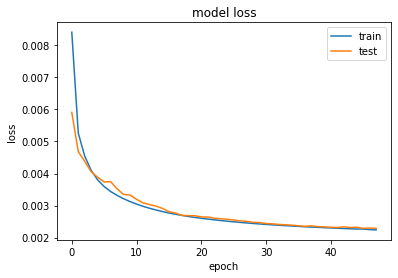

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
loss = model.evaluate(X_test,X_test)
print('INFO: loss on test: {:.4f}'.format(loss))

313/313 [==============================] - 1s 4ms/step - loss: 0.0023
INFO: loss on test: 0.0023


### Store the model

In [ ]:
from google.colab import drive
import datetime
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Souradip Sayak/SimCLR_PseudoLabels/Models/'

In [ ]:
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "autoencoder_cifar10.h5"
filename = path+filename
filename

'/content/drive/My Drive/Colab Notebooks/Souradip Sayak/SimCLR_PseudoLabels/Models/20200821-060112autoencoder_cifar10.h5'

In [ ]:
model.save(filename)

## Evaluation
Let's see the reconstruction the model provides on the unseen test-set

In [ ]:
# Taking 5 images from the test dataset for reconstruction
img = X_test[:5].copy()
rec = model.predict(img)
img.shape, rec.shape

((5, 32, 32, 3), (5, 32, 32, 3))

Test Images


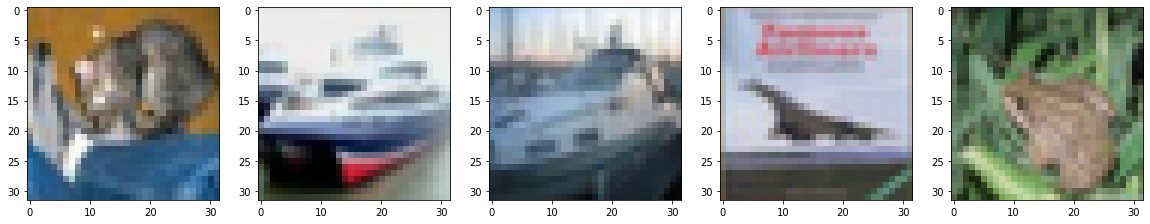

Reconstruction of Test Images


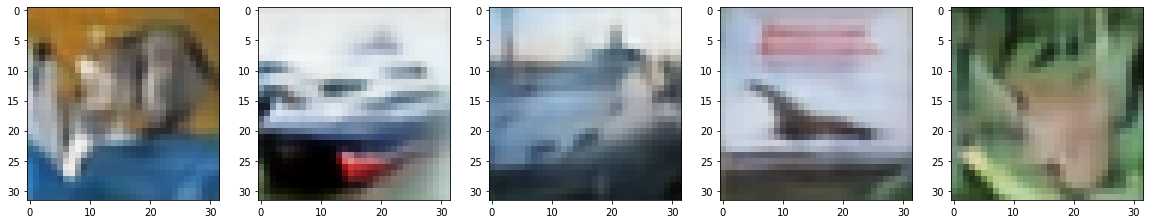

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(img[i])
plt.show() 

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(rec[i])
plt.show()

# Retrieval
This section of the code extracts the embeddings. The embeddings are later used to cluster together to present the t-SNE. The 

In [ ]:
layer_name = 'retrieval'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)       

In [ ]:
latent_train = slice_model.predict(X_train)
latent_test = slice_model.predict(X_test)
latent_train.shape, latent_test.shape

((50000, 4, 4, 128), (10000, 4, 4, 128))

In [ ]:
embedding_train = tf.keras.layers.GlobalAveragePooling2D()(latent_train)
embedding_test = tf.keras.layers.GlobalAveragePooling2D()(latent_test)
embedding_train.shape, embedding_test.shape

(TensorShape([50000, 128]), TensorShape([10000, 128]))

## t-SNE of the latent space
Here we observe the embeddings. This would be a good place to see what is happening in the autoencoder. This would also provide us with the intuitions of clusters.

In [ ]:
tsne_train = TSNE(n_components=2).fit_transform(embedding_train)
tsne_test = TSNE(n_components=2).fit_transform(embedding_test)
tsne_train.shape, tsne_test.shape

((50000, 2), (10000, 2))

In [ ]:
# le = LabelEncoder()
# y_train_enc = le.fit_transform(y_train)
# y_test_enc = le.transform(y_test)

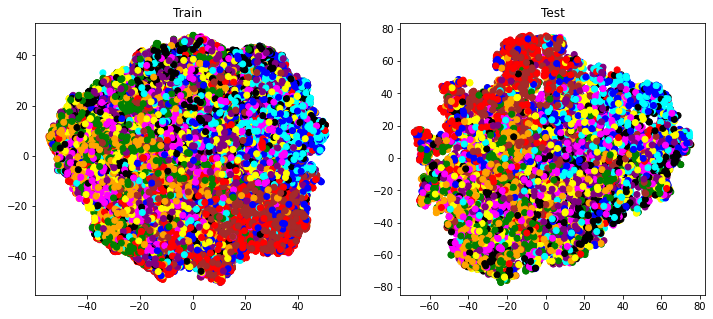

In [ ]:
colors = ['red','green','blue','purple','cyan', 'yellow', 'black', 'magenta','brown','orange']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(tsne_train[:,0],tsne_train[:,1],c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Train')
plt.subplot(1,2,2)
plt.scatter(tsne_test[:,0],tsne_test[:,1],c=y_test, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Test')
plt.show()